In [16]:
from string import ascii_uppercase
from tqdm import tqdm
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt

import torch

from sentence_transformers.util import semantic_search, dot_score, normalize_embeddings
from transformer_lens import HookedTransformer

torch.manual_seed(42);

**What are we trying to do?:** Automatically generating adversarial samples to detect and understand possible vulnerabilities on circuits associated to specific tasks. In this case, we are studying the task of three-letter acronym prediction. First, we will try to generate samples that are **incorrectly predicted by the model**, i.e. certain samples or letters that are incorrectly predicted, hence detecting possible vulnerabilities.

In [17]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
device = torch.device("cpu")
model = model.to(device)
print(f"Model loaded on {device}")

In [ ]:

# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order 
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}

In [20]:
# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [21]:
device = "cpu"

with open("data/acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = 1000
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

tokens = model.to_tokens(prompts)
# ground truth: third letter of the acronym (tokens)
y = model.to_tokens([x[letter] for x in acronyms], prepend_bos=False).squeeze()
with torch.no_grad():
    y_pred = model(tokens)[:, indices_logits[letter]].argmax(dim=-1)
# discard already misclassified samples
tokens = tokens[y_pred == y]
y = y[y_pred == y]
# reupdate n_samples
n_samples = tokens.shape[0]

y_idx = y.cpu().apply_(token_to_idx.get).to(device)

print(f"device used: {device}")

device used: cpu


In [22]:
batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_tokens = sample_tokens.to(device)
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

sample_tokens.shape, sample_embeddings.shape, sample_y.shape, sample_y_idx.shape

(torch.Size([128, 8]),
 torch.Size([128, 8, 768]),
 torch.Size([128]),
 torch.Size([128]))

In [23]:
def project_embeddings(sample_embeddings, embedding_matrix, vocab, mask, sample_tokens):
    """
    Given a batch of sample adversarial embeddings, project 
    them into their closest token in the embedding space.

    Input:
    - `sample_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    - `embedding_matrix`: Tensor of shape (d_vocab, d_model)
    - `vocab`: Tensor of shape (n_vocab,), where n_vocab <= d_vocab, containing
        the list of possible tokens when projecting/updating the samples.
    - `mask`: Tensor of shape (seq_len,). mask[i] = 1 means that the i-th token will be 
    optimized/changed by the algorithm.
    - `sample_tokens`: Tensor of shape (batch_size, seq_len), the original tokens.

    Returns:
    Two tensors containing both the ids and the embedding vectors of the projected vectors.
    - `projected_tokens`: Tensor of shape (batch_size, seq_len)
    - `projected_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    """
    device = sample_embeddings.device  
    vocab_embedding_matrix = normalize_embeddings(embedding_matrix[vocab])
    result = semantic_search(
        normalize_embeddings(sample_embeddings.view(-1, sample_embeddings.shape[-1])),
        vocab_embedding_matrix,
        query_chunk_size=sample_embeddings.shape[0],
        top_k=1,
        score_function=dot_score
    )
    projected_tokens = torch.tensor([vocab[x[0]["corpus_id"]] for x in result]).to(device)
    projected_tokens = projected_tokens.view(sample_embeddings.shape[:-1])  # (batch_size, seq_len)

    # Ensure all tensors are on the same device
    mask = mask.to(device)
    sample_tokens = sample_tokens.to(device)

    projected_tokens = torch.where(mask, projected_tokens, sample_tokens)
    projected_embeddings = embedding_matrix[projected_tokens].clone().detach()
    return projected_tokens, projected_embeddings

In [24]:
def AdvMarginLoss(margin=1.0):
    """
    Create the adversarial Margin Loss
    """
    def loss_fn(logits, y, average=True):
        """
        Return the adversarial margin loss used to generate adversarial samples.

        Parameters:
        - `logits`: Tensor of shape (batch_size, num_classes) containing the logits.
        - `y`: Tensor of shape (batch_size,) containing the index of the ground truth.
        """
        # gather the logits of the ground truth
        logits_correct = logits[torch.arange(0, logits.shape[0]), y] # (batch_size,)
        # retrieve the maximum logits of the incorrect answers
        y_incorrect = torch.ones_like(logits, dtype=bool)
        y_incorrect[torch.arange(0, logits.shape[0]), y] = 0
        max_logits_incorrect = logits[y_incorrect].view(logits.shape[0], -1).max(1).values # (batch_size,)
        loss = (logits_correct - max_logits_incorrect + margin)
        loss = torch.where(loss < 0, torch.zeros_like(loss), loss)

        return loss.mean() if average else loss

    return loss_fn

100%|██████████| 200/200 [05:54<00:00,  1.77s/it]


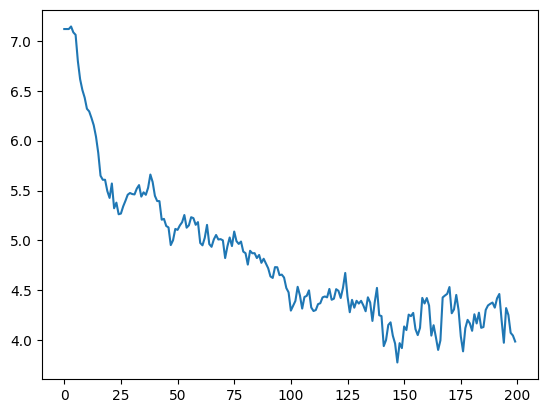

In [25]:
# First test: start with an initial sample, modify just the third capital letter to minimize the adversarial loss, i.e.
# use our algorithm to automatically generate samples that incorrectly predict the third letter, DESPITE being valid sentences!

batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

embedding_matrix = model.W_E


# now the vocabulary of optimization is every single token word possible
with open("data/words_dict.pkl", 'rb') as f:
    words_dict = pickle.load(f)
word_list = [v for _, v in words_dict.items()]
word_list = [x for xs in word_list for x in xs]
vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).to(device)
mask[indices_letters[letter]] = 1

lr=1e-1
weight_decay=1e-1
margin = 4
loss_fn = AdvMarginLoss(margin=margin)

input_optimizer = torch.optim.AdamW([sample_embeddings], lr=lr, weight_decay=weight_decay)

# we will collect the adversarial samples: samples that are incorrectly classified by the model
adv_samples = []
# we also collect the original sample associated to each adversarial sample
original_samples = []
losses = []
# OPTIMIZE
for _ in tqdm(range(200), disable=False):

    # Project the embeddings
    projected_tokens, projected_embeddings = project_embeddings(
    sample_embeddings, embedding_matrix, vocab, mask, sample_tokens
)
    # BRUH this is causing a high bottleneck. Optimize when everything works right
    sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).to(device)

    tmp_embeddings = sample_embeddings.detach().clone()
    tmp_embeddings.data = projected_embeddings.data
    tmp_embeddings.requires_grad = True

    # Take the logits of the subspace
    logits_vocab = model.forward(tmp_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

    loss = loss_fn(logits_vocab, sample_y_idx, average=True)

    sample_embeddings.grad, = torch.autograd.grad(loss, [tmp_embeddings])
    # set the gradient of elements outside the mask to zero
# Ensure mask is on the same device as sample_embeddings
    mask = mask.to(sample_embeddings.device)

    # Set the gradient of elements outside the mask to zero
    sample_embeddings.grad = torch.where(mask[None, ..., None], sample_embeddings.grad, torch.tensor(0., device=sample_embeddings.device))
    input_optimizer.step()
    input_optimizer.zero_grad()
    #print(loss.item())
    #print(model.to_string(projected_tokens))
    losses.append(loss.item())

    with torch.no_grad():
    # Re-project the embeddings
        projected_tokens, projected_embeddings = project_embeddings(
            sample_embeddings, embedding_matrix, vocab, mask, sample_tokens
        )
        sample_y_idx = torch.tensor([
            token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()]
            for x in projected_tokens
        ], dtype=torch.long).to(device)
        # check if there are adversarial samples
        # Take the logits of the subspace
        logits_vocab = model.forward(
            projected_embeddings + model.pos_embed(projected_tokens), start_at_layer=0
        )[:, indices_logits[letter], cap_tokens]

        loss_i = loss_fn(logits_vocab, sample_y_idx, average=False)
        adv_samples.append(projected_tokens[loss_i < margin])  # a loss lower than margin implies that the sample is incorrectly classified
        original_samples.append(sample_tokens[loss_i < margin])

adv_samples = torch.cat(adv_samples, dim=0)  
original_samples = torch.cat(original_samples, dim=0)  

adv_samples_cpu = adv_samples.to(device)  
adv_samples, inverse_indices = torch.unique(adv_samples_cpu, sorted=False, dim=0, return_inverse=True)
adv_samples = adv_samples.to(device)  
inverse_indices = inverse_indices.to(device)

original_samples_unique = torch.zeros_like(adv_samples)
original_samples_unique = original_samples_unique.to(device)

original_samples = original_samples.to(device)

idx_cpu = torch.arange(original_samples.shape[0], device=device)

original_samples_unique[inverse_indices] = original_samples[idx_cpu]

original_samples = original_samples_unique
plt.plot(losses)

In [26]:
adv_samples.shape[0]

414

In [27]:
model.cpu()
adv_token_preds = model(adv_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)
original_token_preds = model(original_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)


for a, b, c, d in zip(model.to_string(adv_samples[:, :indices_logits[letter]+1]), model.to_string(adv_token_preds), model.to_string(original_samples[:, :indices_logits[letter]+1]), model.to_string(original_token_preds)):
    print(c, "->",d)
    print(a, "->",b)
    print("-"*40)

Moving model to device:  cpu
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Angela (TQ -> E
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Leah (TQ -> R
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Byron (TQ -> R
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Ezra (TQ -> R
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Alec (TQ -> X
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Jenna (TQ -> R
----------------------------------------
<|endoftext|>The Trump Quality Oakland (TQ -> O
<|endoftext|>The Trump Quality Abby (TQ -> X
----------------------------------------
<|endoftext|>The York Jess Lu

In [28]:
unique_tokens, count = torch.unique(torch.tensor([model.to_tokens(model.to_string(x)[1], prepend_bos=False).item() for x in adv_samples[:, indices_letters[letter]]], dtype=torch.long), return_counts=True)
unique_caps = model.to_string(unique_tokens)

adv_freq_dict = {}
for c in ascii_uppercase:
    adv_freq_dict[c] = 0

A = []
B = []
for a, b in zip(unique_caps, count):
    adv_freq_dict[a] = b.item()

In [29]:
# save the adversarial samples (note that we discard those whose acronyms are not properly tokenized as 3 tokens!)
with open(f"data/{letter}_adv_acronyms.txt", "a") as f:
    for sentence in model.to_string(adv_samples[:, 1:]):
        acronym = (''.join([c for c in sentence if c.isupper()]))[1:-2]
        if model.to_tokens(acronym, prepend_bos=False).shape[1] == 3:
            f.write(sentence + ", " + acronym + "\n")

/var/folders/s4/rxljrxqs5d9clp4yr9kwnvqc0000gn/T/ipykernel_79195/2597149441.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["adv"] = df["adv"] / df["adv"].sum()


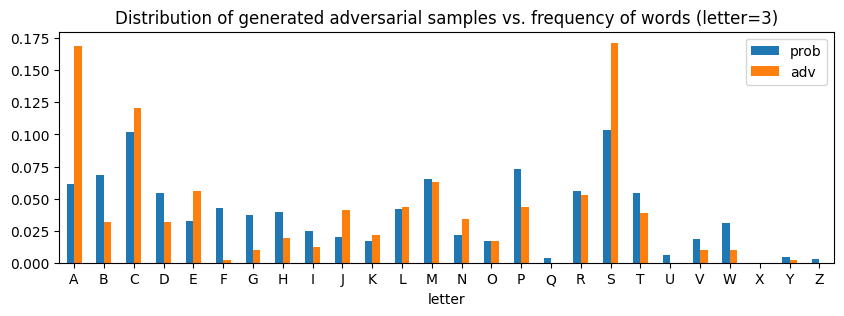

In [30]:
with open("data/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)

prob_dict = {}

n_words = sum([len(v) for _, v in words_dict.items()])

# get the probability of sampling a word beginning by each letter
for k, v in words_dict.items():
    prob_dict[k] = float(len(v)) / n_words

df = pd.DataFrame({"letter": list(ascii_uppercase), "prob": list(prob_dict.values()), "adv": list(adv_freq_dict.values())})
df["adv"] = df["adv"] / df["adv"].sum()
df.plot.bar(x="letter", rot=0, figsize=(10, 3), title=f"Distribution of generated adversarial samples vs. frequency of words (letter={letter+1})");

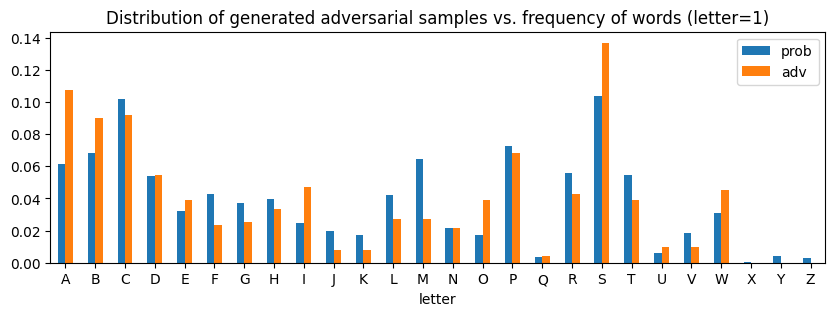

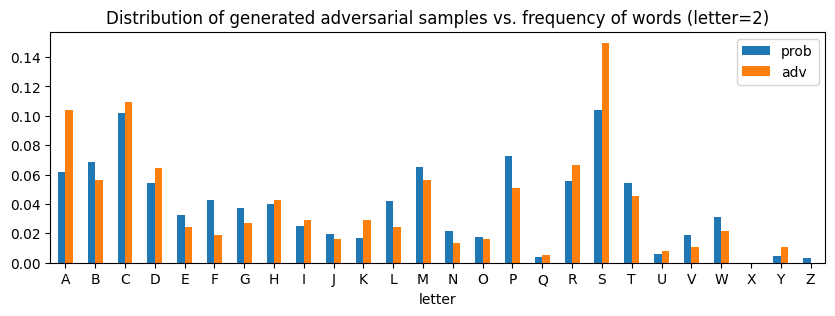

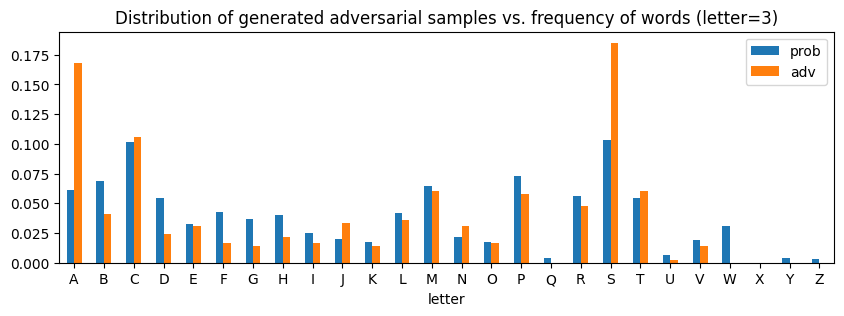